In [1]:
# for some reason my models are not training.. 
# they are accurate to a naive always one output .. 
# which means broken

In [2]:
import numpy as np
import cv2

import matplotlib.pyplot as plt

In [3]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

import libs.metrics

Using TensorFlow backend.


In [4]:
patch_size = 100
samples = 1000

In [5]:
class Trainer:
    def __init__(self, patches, roi):
        self.patches = patches
        self.roi     = roi
        
    def train(self, model):
        metrics = libs.metrics.Metrics()

        stopper = EarlyStopping(monitor='acc', patience=5, verbose=0)
        #model_checkpoint = ModelCheckpoint("testbed_best.hdf5", 
        #    monitor='loss', 
        #    save_best_only=True)

        hist = model.fit(self.patches, self.roi, 
                batch_size=4, 
                epochs=50, verbose=1, shuffle=True,
                #callbacks=[model_checkpoint, metrics],
                callbacks=[stopper, metrics],
                validation_data=(self.patches, self.roi))

        print "final.. "
        print " confusion:"
        print metrics.confusion
        print " precision:", metrics.precision
        print " recall   :", metrics.recall
        print " f1s      :", metrics.f1s
        print " kappa    :", metrics.kappa
        print " auc      :", metrics.auc

In [6]:
class TestGenerator:
    # the idea is simple.. to test a model generate 2-3 classes of objects (circle,square,triangle)
    # if a model cant even class/mask this then the model is a waste of time or broken
    
    def _createCircle(self, width, height, center_x, center_y, radius ):
        Y, X = np.ogrid[:height, :width]
        return np.sqrt((X - center_x)**2 + (Y-center_y)**2) <= radius 
    
    def _createPolygon(self, width, height, points):
        mask = np.zeros((height,width), np.uint8)
        cv2.fillPoly(mask, [points.astype(np.int32)], 1.0)
        return mask

    def _createSquare(self, width, height, top, left, bottom, right):
        points = np.array([[top,   left],
                           [bottom,left],
                           [bottom,right],
                           [top   ,right],
                           [top,   left]])
        return self._createPolygon(width,height, points)

    def _createTriange(self, width, height, top, left, size):
        offset = np.sqrt(0.75) * size
        points = np.array([[top,         left],
                           [top+size,    left],
                           [top+size/2.0,left + offset],
                           [top,         left]])
        return self._createPolygon(width,height, points)
        
    def __init__(self, patch_size):
        self.patch_size = patch_size
    
    def __call__(self, samples, class_roi):
        cir_radius = 0.3 * self.patch_size
        cir_center = 0.5 * self.patch_size
        
        sqr_top_left  = 0.2 * self.patch_size
        sqr_bot_right = 0.8 * self.patch_size
   
        tri_top  = 0.2 * self.patch_size
        tri_left = 0.3 * self.patch_size
        tri_size = 0.6 * self.patch_size
        
        class_out = np.random.randint(3, size=samples)
        patches   = np.zeros((samples,self.patch_size,self.patch_size))
        roi       = class_out == class_roi
        for i in range(samples):
            if class_out[i] == 0:
                patches[i] = self._createSquare(self.patch_size,self.patch_size,
                                                sqr_top_left,sqr_top_left,sqr_bot_right,sqr_bot_right)
            elif class_out[i] == 1:
                patches[i] = self._createCircle(self.patch_size,self.patch_size,
                                                cir_center,cir_center,cir_radius)
            else: # if class_out[i] == 2:
                patches[i] = self._createTriange(self.patch_size,self.patch_size,
                                                 tri_top,tri_left,tri_size)
        return class_out, patches, roi

In [7]:
######################### SET 1 - artifical - 3 simple items #####################

In [8]:
cir_sqr_gen = TestGenerator(patch_size)

In [9]:
classes, patches, roi = cir_sqr_gen(samples, 1)

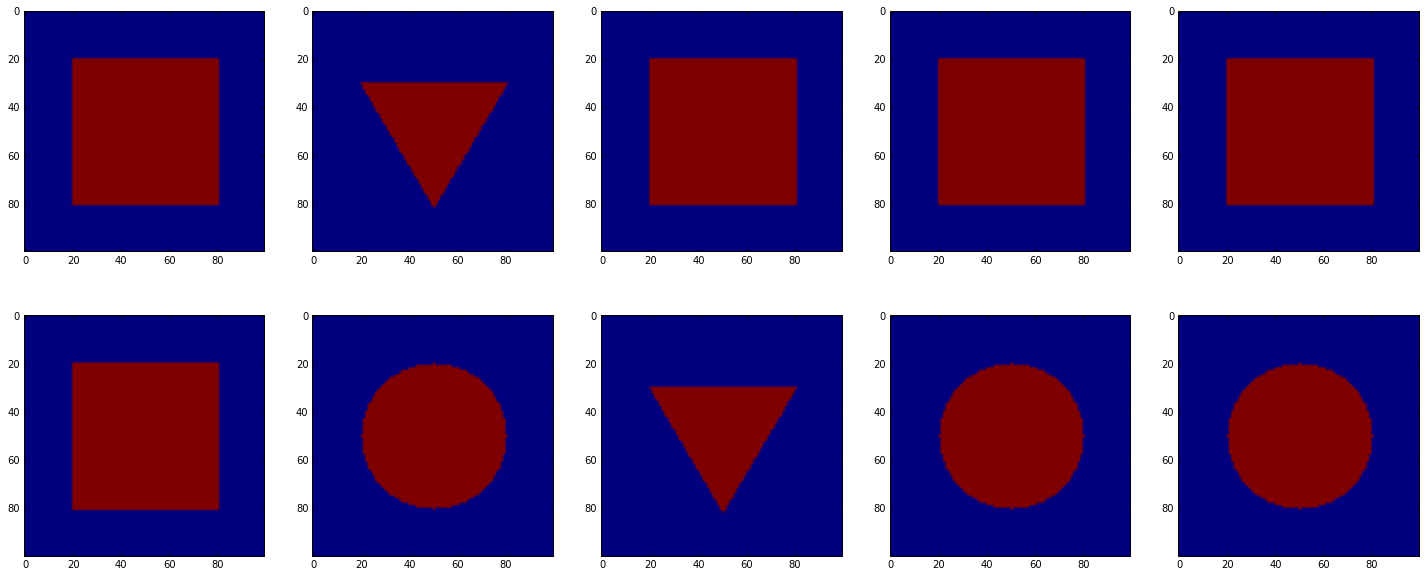

In [10]:
# check what the the circle/square/triangle test set looks lie
display_limit=min(10, patches.shape[0])
cols = 5
rows = int(np.ceil(display_limit/5))
fig, axArr = plt.subplots(figsize=(5*cols, 5*rows), nrows=rows, ncols=cols)  

for i in range(display_limit):
    row = i / cols
    col = i % cols
    axArr[row][col].imshow(patches[i])
plt.show()

In [11]:
print np.sum(roi), "/", roi.shape[0], " (", (float(np.sum(roi)) / roi.shape[0]), ")"

316 / 1000  ( 0.316 )


In [12]:
patches = patches.reshape(patches.shape + (1,))

cir_sqr_trainer = Trainer(patches, roi)

In [13]:
######################### SET 2 - live data set - just small #####################

In [14]:
import  libs.patch_generator

In [15]:
imgs = np.load("../per_class/prep/3band_in.npy")

In [16]:
trees = np.load("../per_class/prep/3band_chan5.npy")  # trees

In [17]:
trees_gen = libs.patch_generator.DataGenerator(imgs,trees,
                                         patchs_per_transform = 100, 
                                         patch_size           = patch_size,
                                         mode                 = libs.patch_generator.DataGenerator.ROI)

patches,roi = trees_gen(epochs=1, samples=samples).next()

/usr/local/lib/python2.7/dist-packages/keras/preprocessing/image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (25, 3403, 3403, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [18]:
# at this poin the raw data and generators are done..
print patches.shape
print roi.shape

(1000, 100, 100, 3)
(1000, 1)


In [19]:
del trees
del trees_gen

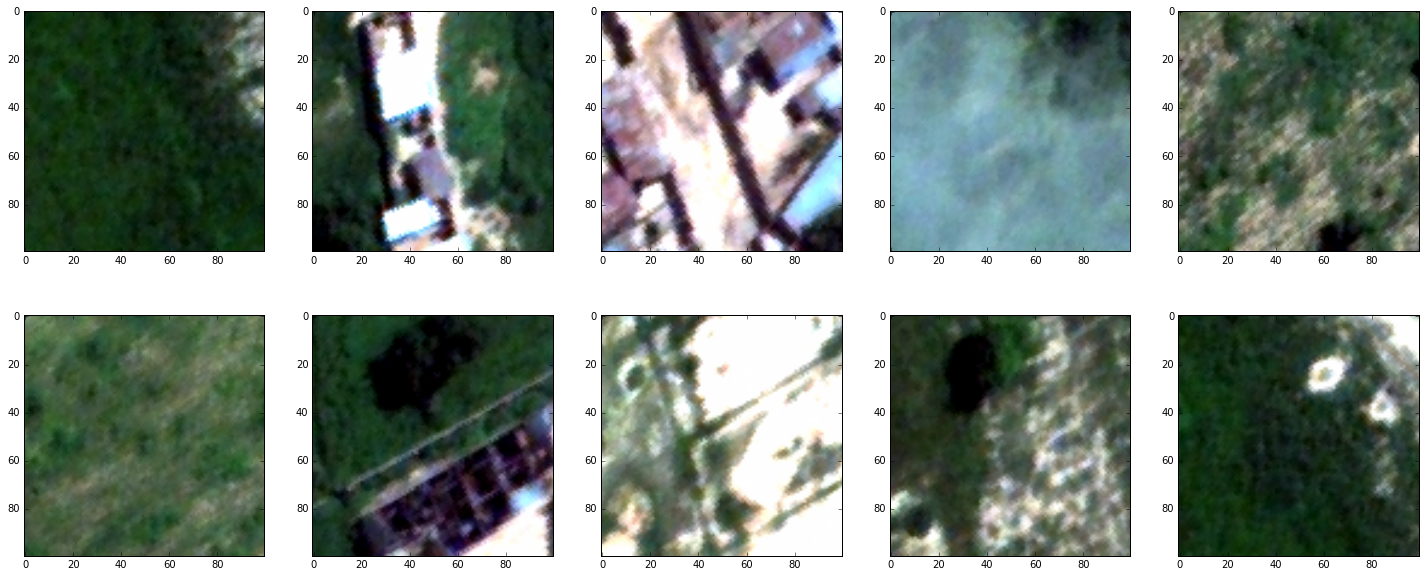

In [20]:
# check what the the circle/square/triangle test set looks lie
display_limit=min(10, patches.shape[0])
cols = 5
rows = int(np.ceil(display_limit/5))
fig, axArr = plt.subplots(figsize=(5*cols, 5*rows), nrows=rows, ncols=cols)  

for i in range(display_limit):
    row = i / cols
    col = i % cols
    axArr[row][col].imshow(patches[i])
plt.show()

In [21]:
print np.sum(roi), "/", roi.shape[0], " (", (float(np.sum(roi)) / roi.shape[0]), ")"

721.0 / 1000  ( 0.721 )


In [22]:
tree_trainer = Trainer(patches, roi)

In [23]:
######################### SET 3 - live data set - just small #####################

In [24]:
buildings = np.load("../per_class/prep/3band_chan1.npy")  # buildings

In [25]:
buildings_gen = libs.patch_generator.DataGenerator(imgs,buildings,
                                         patchs_per_transform = 100, 
                                         patch_size           = patch_size,
                                         mode                 = libs.patch_generator.DataGenerator.ROI)

patches,roi = buildings_gen(epochs=1, samples=samples).next()

In [26]:
# at this poin the raw data and generators are done..
print patches.shape
print roi.shape

(1000, 100, 100, 3)
(1000, 1)


In [27]:
del buildings
del buildings_gen

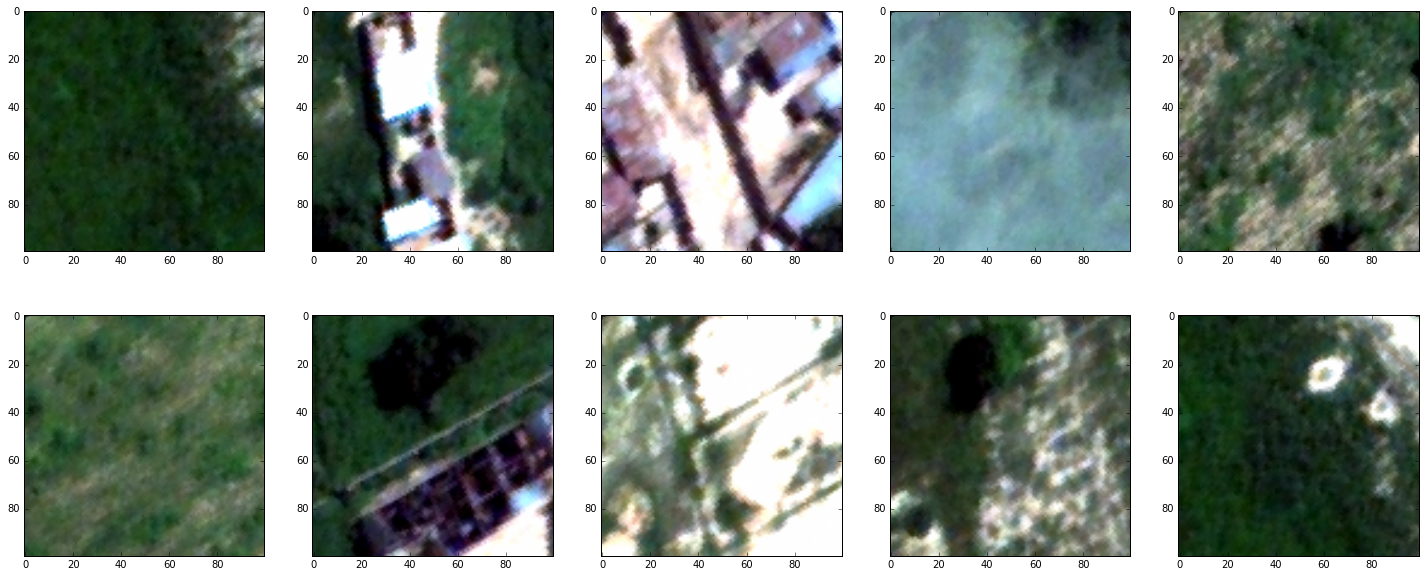

In [28]:
# check what the the circle/square/triangle test set looks lie
display_limit=min(10, patches.shape[0])
cols = 5
rows = int(np.ceil(display_limit/5))
fig, axArr = plt.subplots(figsize=(5*cols, 5*rows), nrows=rows, ncols=cols)  

for i in range(display_limit):
    row = i / cols
    col = i % cols
    axArr[row][col].imshow(patches[i])
plt.show()

In [29]:
print np.sum(roi), "/", roi.shape[0], " (", (float(np.sum(roi)) / roi.shape[0]), ")"

284.0 / 1000  ( 0.284 )


In [30]:
building_trainer = Trainer(patches, roi)

In [31]:
######################### begin testing #####################

In [32]:
#################### MODEL 1 #####################

In [33]:
import test_models

In [34]:
model = test_models.setup_model_1(patch_size=patch_size, in_chan=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# cir\sqr naive 0.333
cir_sqr_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 1s - loss: 0.0240 - acc: 0.9930 - f1_score: 0.7736 - precision: 0.7730 - recall: 0.7760 - val_loss: 9.3224e-04 - val_acc: 1.0000 - val_f1_score: 0.7880 - val_precision: 0.7880 - val_recall: 0.7880

In [36]:
model = test_models.setup_model_1(patch_size=patch_size, in_chan=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 30001     
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# tree naive 0.721
tree_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 1s - loss: 1.8533 - acc: 0.6340 - f1_score: 0.6691 - precision: 0.6577 - recall: 0.7643 - val_loss: 1.9988 - val_acc: 0.7190 - val_f1_score: 0.8046 - val_precision: 0.7243 - val_recall: 0.9807

In [38]:
# tree naive 0.284
building_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 1s - loss: 4.0066 - acc: 0.6750 - f1_score: 0.0556 - precision: 0.0533 - recall: 0.0720 - val_loss: 4.5689 - val_acc: 0.7140 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

In [ ]:
#################### MODEL 2 #####################

In [39]:
model = test_models.setup_model_2(patch_size=patch_size, in_chan=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 80001     
Total params: 89,569
Trainable params: 89,569
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# cir\sqr naive 0.333
cir_sqr_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 4s - loss: 0.0283 - acc: 0.9910 - f1_score: 0.7600 - precision: 0.7600 - recall: 0.7600 - val_loss: 1.3341e-05 - val_acc: 1.0000 - val_f1_score: 0.7880 - val_precision: 0.7880 - val_recall: 0.7880

In [41]:
model = test_models.setup_model_2(patch_size=patch_size, in_chan=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 80001     
Total params: 90,145
Trainable params: 90,145
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# tree naive 0.721
tree_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 4s - loss: 0.6364 - acc: 0.7170 - f1_score: 0.8073 - precision: 0.7150 - recall: 0.9840 - val_loss: 0.5785 - val_acc: 0.7210 - val_f1_score: 0.8083 - val_precision: 0.7210 - val_recall: 0.9960

In [ ]:
# tree naive 0.284
building_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 4s - loss: 1.0097 - acc: 0.6770 - f1_score: 0.0784 - precision: 0.0913 - recall: 0.0807 - val_loss: 0.6337 - val_acc: 0.7140 - val_f1_score: 0.0020 - val_precision: 0.0040 - val_recall: 0.0013

In [ ]:
#################### MODEL 3 #####################

In [44]:
model = test_models.setup_model_3(patch_size=patch_size, in_chan=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 64)        0         
__________

In [45]:
# cir\sqr naive 0.333
cir_sqr_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 7s - loss: 0.0254 - acc: 0.9930 - f1_score: 0.7560 - precision: 0.7560 - recall: 0.7560 - val_loss: 1.0607e-07 - val_acc: 1.0000 - val_f1_score: 0.7880 - val_precision: 0.7880 - val_recall: 0.7880

In [46]:
model = test_models.setup_model_3(patch_size=patch_size, in_chan=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 64)        0         
__________

In [ ]:
# tree naive 0.721    --- NOTE FAILED
tree_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 8s - loss: 0.6163 - acc: 0.7140 - f1_score: 0.8004 - precision: 0.7090 - recall: 0.9660 - val_loss: 0.6002 - val_acc: 0.7210 - val_f1_score: 0.8083 - val_precision: 0.7210 - val_recall: 0.9960

In [ ]:
# tree naive 0.284
building_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
 820/1000 [=======================>......] - ETA: 0s - loss: 0.6594 - acc: 0.6134 - f1_score: 0.1120 - precision: 0.0793 - recall: 0.2195                

In [ ]:
#################### MODEL 4 #####################

In [ ]:
model = test_models.setup_model_4(patch_size=patch_size, in_chan=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 64)        0         
__________

In [ ]:
cir_sqr_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 11s - loss: 0.1109 - acc: 0.9340 - f1_score: 0.6328 - precision: 0.6310 - recall: 0.6400 - val_loss: 1.0601e-07 - val_acc: 1.0000 - val_f1_score: 0.8320 - val_precision: 0.8320 - val_recall: 0.8320

In [ ]:
model = test_models.setup_model_5(patch_size=patch_size, in_chan=1)

In [ ]:
cir_sqr_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 11s - loss: 5.1701 - acc: 0.5090 - f1_score: 0.2147 - precision: 0.1627 - recall: 0.3720 - val_loss: 11.0481 - val_acc: 0.3070 - val_f1_score: 0.4245 - val_precision: 0.3070 - val_recall: 0.7800

In [ ]:
# model death.. it seems if the cnn tightens in too much it kills the model.. seems 6x6 is ok.. but 3x3 is dead

In [50]:
model = test_models.setup_model_actual(patch_size=patch_size, in_chan=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 25, 25, 64)        0         
__________

In [51]:
cir_sqr_trainer.train(model)

Train on 1000 samples, validate on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 10s - loss: 0.2768 - acc: 0.8670 - f1_score: 0.5163 - precision: 0.5150 - recall: 0.5200 - val_loss: 6.2559e-07 - val_acc: 1.0000 - val_f1_score: 0.8280 - val_precision: 0.8280 - val_recall: 0.8280